In [156]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

from sklearn.tree import DecisionTreeClassifier as Tree
from graspologic.cluster import GaussianCluster as GMM
from sklearn.ensemble import RandomForestClassifier
from sklearn import random_projection

from rsq import SSRF
from rsq.helpers import stratified_sample

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import numba

In [2]:
def few_shot_gaussians(n, d, n_classes=2, type2_var=0.5, var=1, n_labels_per_class=1, n_test=100, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
                
    means = np.random.multivariate_normal(np.zeros(d), type2_var * np.eye(d), size=int(n_classes))
            
    data = np.concatenate([np.random.multivariate_normal(mean, var*np.eye(d), size=n) for mean in means])
    latent_labels = np.concatenate([i*np.ones(n) for i in range(n_classes)])
    
    data_test = np.concatenate([np.random.multivariate_normal(mean, var*np.eye(d), size=n_test) for mean in means])
    y_test = np.concatenate([i*np.ones(n_test) for i in range(n_classes)])
    
    shuf = np.random.choice(n_classes*n, n_classes*n, replace=False)
    data, latent_labels = data[shuf], latent_labels[shuf]
    
    known_labels = -1 * np.ones(n_classes*n)
    labeled_inds = [np.where(latent_labels == i)[0][:n_labels_per_class] for i in range(n_classes)]
    
    for i, inds in enumerate(labeled_inds):
        known_labels[inds] = i
                
    return data, known_labels, latent_labels, data_test, y_test

In [163]:
%load_ext autoreload
%autoreload

def random_forest_exp(label_noise=0, n=1000, d=10, n_classes=10, cc=0.5, c=0.75, n_labels_per_class=50, acorn=None, algorithm_indices=np.arange(4)):
    accs = np.zeros(len(algorithm_indices))
    X, y, y_true, X_test, y_test = few_shot_gaussians(n, d, n_classes, cc, c, n_labels_per_class, 100, acorn)
    
    inds_sup = np.where(y != -1)[0]
    inds_to_change = np.random.binomial(1, p=label_noise, size=len(inds_sup)).astype(bool)
    new_labels = np.random.choice(np.unique(y_true), np.sum(inds_to_change), replace=True)
    
    y[inds_sup[inds_to_change]] = new_labels
    
    n_t=50
            
    if 0 in algorithm_indices:
        urf = SSRF(n_sup=0, n_semisup=n_t, sup_weight=0, p_inbag=0.67,
                  cluster_class='gmm', cluster_kwargs={'n_components': -2, 'covariance_type': 'spherical'}, n_jobs=1)
        urf.fit(X, y)
        accs[np.where(algorithm_indices == 0)[0][0]] = np.mean(urf.predict(X_test) == y_test)

    if 1 in algorithm_indices:
        halfrf = SSRF(n_sup=int(n_t/2), n_semisup=int(n_t/2), sup_weight=0.5, p_inbag=0.67, classes=np.arange(n_classes),
                     cluster_class='gmm', cluster_kwargs={'n_components': -2, 'covariance_type': 'spherical'}, n_jobs=1)
        halfrf.fit(X, y)
        accs[np.where(algorithm_indices == 1)[0][0]] = np.mean(halfrf.predict(X_test) == y_test)

    if 2 in algorithm_indices:
        ratiorf = SSRF(n_sup=int(n_t/2), n_semisup=int(n_t/2), sup_weight=None, p_inbag=0.67, classes=np.arange(n_classes),
                      cluster_class='gmm', cluster_kwargs={'n_components': -2, 'covariance_type': 'spherical'}, n_jobs=1)
        ratiorf.fit(X, y)
        accs[np.where(algorithm_indices == 2)[0][0]] = np.mean(ratiorf.predict(X_test) == y_test)

    if 3 in algorithm_indices:
        rf = SSRF(n_sup=n_t, n_semisup=0, sup_weight=1, p_inbag=0.67, classes=np.arange(n_classes), n_jobs=1)
        rf.fit(X, y)
        accs[np.where(algorithm_indices == 3)[0][0]] = np.mean(rf.predict(X_test) == y_test)
    
    if 4 in algorithm_indices:
        randrf = SSRF(n_sup=int(n_t/2), n_semisup=int(n_t/2), sup_weight=None, p_inbag=0.67, classes=np.arange(n_classes), n_jobs=1,
                          cluster_class='gmm', cluster_kwargs={'n_components': -2, 'covariance_type': 'spherical'},
                          projector='gaussian', projection_kwargs={'n_components': 5})
        randrf.fit(X, y)
        accs[np.where(algorithm_indices == 4)[0][0]] = np.mean(randrf.predict(X_test) == y_test)
        
    if 5 in algorithm_indices:
        cluster=ClusterClassifier(gmm)
        cluster.fit(X, y)
        accs[np.where(algorithm_indices == 5)[0][0]] = np.mean(cluster.predict(X_test) == y_test)
    
    return accs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
run_experiment=True

np.random.seed(2)

props = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]
label_noise=0
n=100
d=5
c=0.5
cc = 0.25
n_classes=10


n_mc = 30
n_cores=30

# algorithm_indices=np.arange(4)
algorithm_indices=np.array([0,1,3])
# algorithm_indices=np.array([4])


# accs = np.zeros((len(props), len(algorithm_indices), n_mc))
accs2= np.zeros((len(props), len(algorithm_indices), n_mc))

print(algorithm_indices)




if run_experiment:
    experiment_tuples=[]
    for i, p in enumerate(props):
        seeds = np.random.randint(0, 10000, size=n_mc)
        for j in range(n_mc):
            experiment_tuples.append((int(n*p), seeds[j]))
       
    results = np.array(Parallel(n_jobs=90)(delayed(condensed_func)(x) for x in experiment_tuples))
        
    accs = np.zeros((len(props), len(algorithm_indices), n_mc))
    for i, tupl in enumerate(results):
        accs[ int(np.math.floor( i / n_mc ) ), : , i % n_mc ] = tupl

[0 1 3]
[[0.245 0.229 0.219]
 [0.248 0.22  0.199]
 [0.092 0.091 0.104]
 [0.303 0.264 0.233]
 [0.343 0.241 0.207]
 [0.168 0.231 0.192]
 [0.285 0.244 0.184]
 [0.209 0.184 0.149]
 [0.197 0.202 0.148]
 [0.197 0.227 0.198]
 [0.279 0.239 0.164]
 [0.128 0.125 0.11 ]
 [0.314 0.248 0.151]
 [0.319 0.255 0.208]
 [0.26  0.227 0.16 ]
 [0.25  0.197 0.137]
 [0.223 0.152 0.139]
 [0.286 0.299 0.204]
 [0.172 0.214 0.21 ]
 [0.237 0.19  0.15 ]
 [0.332 0.194 0.146]
 [0.214 0.19  0.179]
 [0.281 0.239 0.209]
 [0.162 0.162 0.142]
 [0.24  0.16  0.16 ]
 [0.191 0.181 0.167]
 [0.145 0.122 0.108]
 [0.193 0.186 0.158]
 [0.223 0.222 0.179]
 [0.185 0.141 0.119]
 [0.262 0.238 0.249]
 [0.222 0.198 0.137]
 [0.199 0.184 0.146]
 [0.256 0.206 0.132]
 [0.233 0.226 0.207]
 [0.208 0.206 0.125]
 [0.295 0.255 0.2  ]
 [0.229 0.22  0.174]
 [0.321 0.318 0.222]
 [0.268 0.281 0.221]
 [0.243 0.211 0.199]
 [0.252 0.229 0.183]
 [0.296 0.268 0.194]
 [0.22  0.221 0.203]
 [0.202 0.221 0.178]
 [0.238 0.23  0.192]
 [0.254 0.241 0.185]
 [0.2

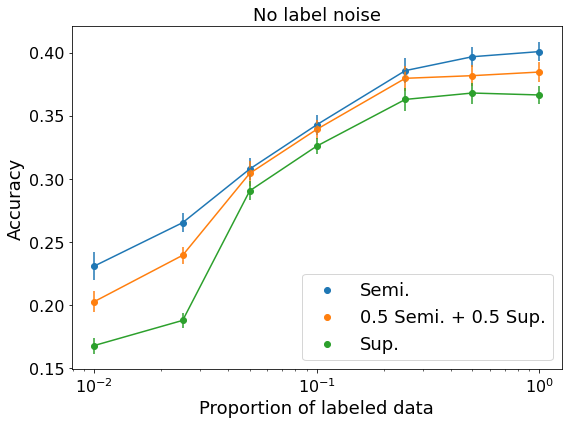

In [120]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

labels=['Semi.', '0.5 Semi. + 0.5 Sup.', 'Sup.',]

# run_experiment=False

# if run_experiment:
#     means = np.mean(accs, axis=-1).T
#     stds = np.std(accs, axis=-1).T / np.sqrt(n_mc)

#     pickle.dump(means, open('data/forests_meanaccs_fewshotgaussians.pkl', 'wb'))
#     pickle.dump(stds, open('data/forests_stdaccs_fewshotgaussians.pkl', 'wb'))
    
# else:
#     means = pickle.load(open('data/forests_meanaccs_fewshotgaussians.pkl', 'rb'))
#     stds = pickle.load(open('data/forests_stdaccs_fewshotgaussians.pkl', 'rb'))

means = np.mean(accs, axis=-1).T
stds = np.std(accs, axis=-1).T / np.sqrt(n_mc)
for i, mean in enumerate(means):
    ax.scatter(props, mean, label=labels[i])
    ax.errorbar(props, mean, yerr=stds[i])

ax.set_xscale('log')
ax.legend(fontsize=18)
ax.set_xlabel('Proportion of labeled data', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
ax.tick_params(labelsize=16)

ax.set_title('No label noise', fontsize=18)
plt.tight_layout()

In [165]:
run_experiment=True

np.random.seed(2)

ns = [10, 25, 50, 100]
label_noise_list = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8]

n_l = len(label_noise_list)
n_n = len(ns)

n=100
d=10
c=0.5
cc = 0.25
n_classes=10
n_labeled_per_class=10


n_mc = 60

# algorithm_indices=np.arange(4)
algorithm_indices=np.array([0,1,3])
# algorithm_indices=np.array([4])


# accs = np.zeros((len(props), len(algorithm_indices), n_mc))
accs2= np.zeros((len(props), len(algorithm_indices), n_mc))

print(algorithm_indices)

if run_experiment:
    condensed_func = lambda x: random_forest_exp(x[0], n, d, n_classes, cc, c, n_labeled_per_class, x[1], algorithm_indices)
    experiment_tuples = []
    for ell, label_noise in enumerate(label_noise_list):
        for i, p in enumerate(ns):
            seeds = np.random.randint(0, 10000, size=n_mc)
            for j in range(n_mc):
                experiment_tuples.append((label_noise, seeds[j]))
                
    
    results_ln = np.array(Parallel(n_jobs=90)(delayed(condensed_func)(x) for x in experiment_tuples))
    
    accs_ln = np.zeros((n_l, n_n, len(algorithm_indices), n_mc))
    for i, tupl in enumerate(results_ln):
        accs_ln[int(np.math.floor(i / (n_mc * n_n))), int(np.math.floor(i/n_mc)) % n_n, :, i % n_mc] = tupl

[0 1 3]


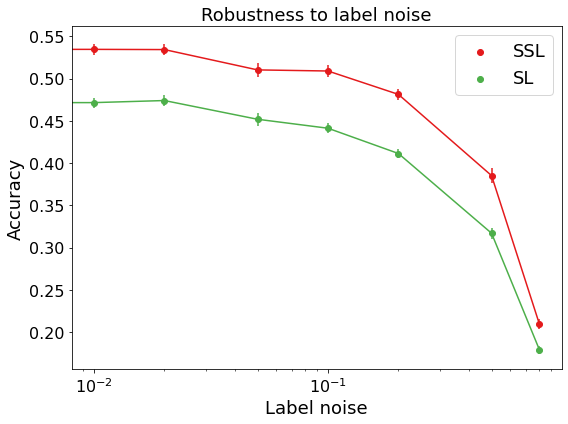

In [174]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

labels=['Semi.', '0.5 Semi. + 0.5 Sup.', 'Sup.',]

# run_experiment=False

# if run_experiment:
#     means = np.mean(accs, axis=-1).T
#     stds = np.std(accs, axis=-1).T / np.sqrt(n_mc)

#     pickle.dump(means, open('data/forests_meanaccs_fewshotgaussians.pkl', 'wb'))
#     pickle.dump(stds, open('data/forests_stdaccs_fewshotgaussians.pkl', 'wb'))
    
# else:
#     means = pickle.load(open('data/forests_meanaccs_fewshotgaussians.pkl', 'rb'))
#     stds = pickle.load(open('data/forests_stdaccs_fewshotgaussians.pkl', 'rb'))

means = np.mean(accs_ln, axis=-1).T
stds = np.std(accs_ln, axis=-1).T / np.sqrt(n_mc)
colors = sns.color_palette("Set1", n_colors=n_n)

ls = ['-', '--', ':']
labels=['SSL', '', 'SL']
for i, mean in enumerate(means):
    if i != 1:
        for j, mea in enumerate(mean):
            if j==0:
                ax.scatter(label_noise_list, mea, color=colors[i], ls = ls[0], label=labels[i])
                ax.errorbar(label_noise_list, mea, yerr=stds[i,j], color=colors[i], ls=ls[0])

ax.set_xscale('log')
ax.legend(fontsize=18)
ax.set_xlabel('Label noise', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
ax.tick_params(labelsize=16)

ax.set_title('Robustness to label noise', fontsize=18)
plt.tight_layout()

In [176]:
from sklearn.neighbors import KNeighborsClassifier
def knn_exp(label_noise=0, n=1000, d=10, n_classes=10, cc=0.5, c=0.75, n_labels_per_class=50, acorn=None, neighbors=np.arange(4)):
    accs = np.zeros(len(neighbors))
    X, y, y_true, X_test, y_test = few_shot_gaussians(n, d, n_classes, cc, c, n_labels_per_class, 100, acorn)
    
    inds_sup = np.where(y != -1)[0]
    inds_to_change = np.random.binomial(1, p=label_noise, size=len(inds_sup)).astype(bool)
    new_labels = np.random.choice(np.unique(y_true), np.sum(inds_to_change), replace=True)
    
    y[inds_sup[inds_to_change]] = new_labels
    
    for i, n_neighbors in enumerate(n_neighbors_list):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X[inds_sup], y[inds_sup])
        accs[i] = np.mean(knn.predict(X_test) == y_test)
        
    return accs

In [193]:
run_experiment=True

np.random.seed(2)

ns=[10]
label_noise_list=[0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8]

n_neighbors_list=[1,21,51]

n_l=len(label_noise_list)
n_n=len(ns)

n=100
d=10
c=0.5
cc=0.25
n_classes=10
n_labeled_per_class=10


n_mc=60

# algorithm_indices=np.arange(4)
algorithm_indices=np.array([0,1,3])
# algorithm_indices=np.array([4])


# accs = np.zeros((len(props), len(algorithm_indices), n_mc))
accs2= np.zeros((len(props), len(algorithm_indices), n_mc))

print(algorithm_indices)

if run_experiment:
    condensed_func = lambda x: knn_exp(x[0], n, d, n_classes, cc, c, n_labeled_per_class, x[1], n_neighbors_list)
    experiment_tuples = []
    for ell, label_noise in enumerate(label_noise_list):
        for i, p in enumerate(ns):
            seeds = np.random.randint(0, 10000, size=n_mc)
            for j in range(n_mc):
                experiment_tuples.append((label_noise, seeds[j]))
                
    
    results_ln_knn = np.array(Parallel(n_jobs=90)(delayed(condensed_func)(x) for x in experiment_tuples))
    
    accs_ln_knn = np.zeros((n_l, n_n, len(n_neighbors_list), n_mc))
    for i, tupl in enumerate(results_ln_knn):
        accs_ln_knn[int(np.math.floor(i / (n_mc * n_n))), int(np.math.floor(i/n_mc)) % n_n, :, i % n_mc] = tupl

[0 1 3]


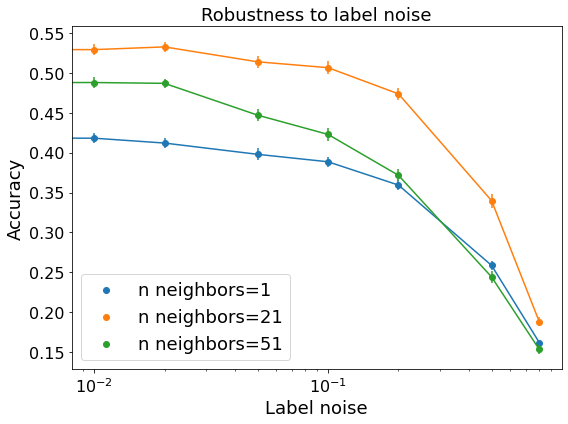

In [195]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

labels=['Semi.', '0.5 Semi. + 0.5 Sup.', 'Sup.',]

# run_experiment=False

# if run_experiment:
#     means = np.mean(accs, axis=-1).T
#     stds = np.std(accs, axis=-1).T / np.sqrt(n_mc)

#     pickle.dump(means, open('data/forests_meanaccs_fewshotgaussians.pkl', 'wb'))
#     pickle.dump(stds, open('data/forests_stdaccs_fewshotgaussians.pkl', 'wb'))
    
# else:
#     means = pickle.load(open('data/forests_meanaccs_fewshotgaussians.pkl', 'rb'))
#     stds = pickle.load(open('data/forests_stdaccs_fewshotgaussians.pkl', 'rb'))

means = np.mean(accs_ln_knn, axis=-1).T
stds = np.std(accs_ln_knn, axis=-1).T / np.sqrt(n_mc)
colors = sns.color_palette("Set1", n_colors=n_n)

ls = ['-', '--', ':']
for i, mean in enumerate(means):
    for j, mea in enumerate(mean):
        if j==0:
            ax.scatter(label_noise_list, mea, ls = ls[0], label="n neighbors=%i"%(n_neighbors_list[i]))
            ax.errorbar(label_noise_list, mea, yerr=stds[i,j], ls=ls[0])

ax.set_xscale('log')
ax.legend(fontsize=18)
ax.set_xlabel('Label noise', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
ax.tick_params(labelsize=16)

ax.set_title('Robustness to label noise', fontsize=18)
plt.tight_layout()